# Model Training: Centers - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Center position. Choice of features is based on the EDA done in 01_F_EDA.ipynb (Folder 4_ExploratoryDataAnalysis)

## Import our data

In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.model_selection import  KFold
import shap
shap.initjs()

In [91]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [92]:
centers = data[data['POSITION'].isin(['c, l', 'c', 'c, r'])].copy()

# Select only players with 41 or more games played
centers_41GP = centers[(centers['GP'] >= 41)].copy()
test_train_data = centers_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

In [93]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1500, max_depth=5, reg_lambda=2, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]

# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

# # Print the training performance score
# print(f'Training Score: {pipeline.score(X_train, y_train)}')
# # Print the testing performance score
# print(f'Testing Score: {pipeline.score(X_test, y_test)}')

In [94]:
# Assuming 'test_train_data' and 'numerical_features' are defined as in your script
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=1000, max_depth=5, reg_lambda=2, eta=0.01)

# Define the pipeline as before
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross-validation for automated feature selection
# Set min_features_to_select to 1 to ensure at least one feature is selected
# cv=n for n-fold cross-validation
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(2), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')

Mean Squared Error: 0.00047749513889577014
Optimal number of features : 44


In [95]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

# 
# Training performance score: -0.9545108043315635
# Testing performance score: -1.0734563919849927

Training performance score: -0.013961166492288513
Testing performance score: -0.06807155230059658


/Users/michaelkuby/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/Users/michaelkuby/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [96]:
# Save the model to a file
import joblib

model_dir = 'Center_Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

joblib.dump(pipeline, f'{model_dir}/center_salary_pipeline.pkl')
joblib.dump(numerical_features, f'{model_dir}/center_salary_features.pkl')

['Center_Model/center_salary_features.pkl']

In [97]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [98]:
# Create a feature column in Centers for the predicted salary
centers['PRED_SALARY_PERCENTAGE'] = pipeline.predict(centers)

# Create a column for the actual predicted salary
centers['PRED_AAV'] = centers['PRED_SALARY_PERCENTAGE'] * centers['SALARY CAP']
centers['PRED_AAV'] = centers['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
centers['DIFF'] = centers['PRED_AAV'] - centers['AAV']

# Convert to dollars
centers['PRED_AAV'] = convert_to_dollars(centers, 'PRED_AAV')
centers['AAV'] = convert_to_dollars(centers, 'AAV')
centers['DIFF'] = convert_to_dollars(centers, 'DIFF')

In [99]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = centers.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON'] + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
7617,connor mcdavid,2018-19,"$12,500,000.00","$11,775,012.00","$-724,988.00",0.148113
1454,sidney crosby,2009-10,"$8,700,000.00","$8,273,227.00","$-426,773.00",0.145655
11570,connor mcdavid,2023-24,"$12,500,000.00","$12,157,337.00","$-342,663.00",0.145597
41,brad richards,2007-08,"$7,800,000.00","$7,192,375.00","$-607,625.00",0.142990
9833,auston matthews,2021-22,"$11,640,250.00","$11,556,465.00","$-83,785.00",0.141797
881,sidney crosby,2008-09,"$8,700,000.00","$7,992,020.00","$-707,980.00",0.140953
9045,auston matthews,2020-21,"$11,640,250.00","$11,470,864.00","$-169,386.00",0.140747
1732,evgeni malkin,2010-11,"$8,700,000.00","$8,338,285.00","$-361,715.00",0.140375
2069,sidney crosby,2010-11,"$8,700,000.00","$8,332,114.00","$-367,886.00",0.140271
1141,evgeni malkin,2009-10,"$8,700,000.00","$7,884,657.00","$-815,343.00",0.138814


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Centers')

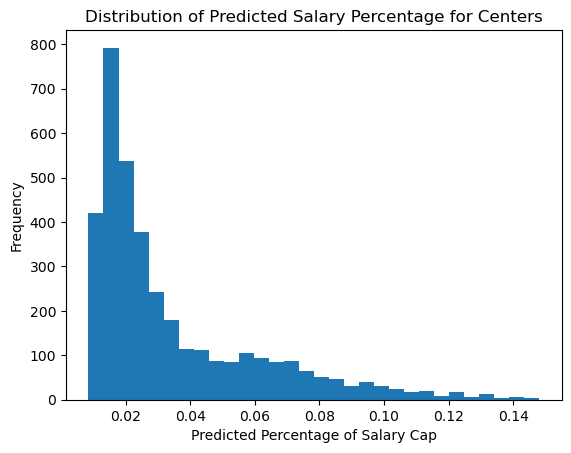

In [100]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(centers['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Percentage of Salary Cap')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Centers')

Text(0.5, 1.0, 'Actual Distribution of Salary Cap Percentage for Centers')

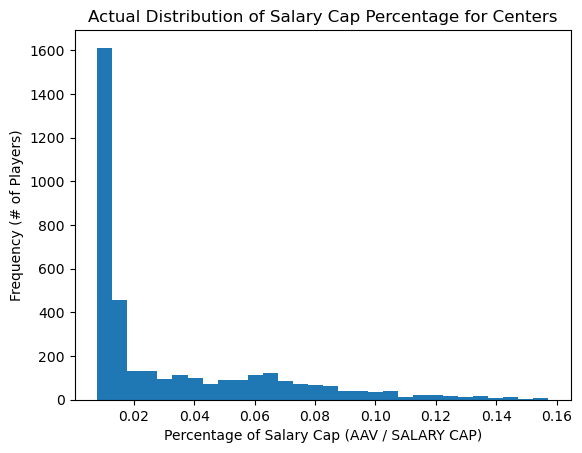

In [101]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(centers['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Percentage of Salary Cap (AAV / SALARY CAP)')
plt.ylabel('Frequency (# of Players)')
plt.title('Actual Distribution of Salary Cap Percentage for Centers')

In [102]:
# Filter players with over 41 GP
filtered_data = centers[(centers['GP'] > 60) & (centers['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11565,nsh,colton sissons,2023-24,"$2,857,143.00","$5,026,254.00","$2,169,111.00",0.060195,2169111.0
12045,"mtl, wpg",sean monahan,2023-24,"$2,000,000.00","$4,064,233.00","$2,064,233.00",0.048673,2064233.0
12138,cgy,yegor sharangovich,2023-24,"$3,100,000.00","$5,078,329.00","$1,978,329.00",0.060818,1978329.0
11851,car,martin necas,2023-24,"$3,000,000.00","$4,739,532.00","$1,739,532.00",0.056761,1739532.0
12055,pit,sidney crosby,2023-24,"$8,700,000.00","$10,280,645.00","$1,580,645.00",0.123122,1580645.0
11810,edm,leon draisaitl,2023-24,"$8,500,000.00","$9,824,077.00","$1,324,077.00",0.117654,1324077.0
11571,wsh,connor mcmichael,2023-24,"$863,333.00","$2,160,399.00","$1,297,066.00",0.025873,1297066.0
11463,fla,anton lundell,2023-24,"$1,775,000.00","$3,037,406.00","$1,262,406.00",0.036376,1262406.0
11917,ari,nick bjugstad,2023-24,"$2,100,000.00","$3,334,058.00","$1,234,058.00",0.039929,1234058.0
12133,dal,wyatt johnston,2023-24,"$1,000,417.00","$2,226,224.00","$1,225,807.00",0.026661,1225807.0


In [103]:
# Display all seasons for Connor McDavid
connor_mcdavid = centers[centers['PLAYER'] == 'connor mcdavid']
connor_mcdavid[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
5276,connor mcdavid,2015-16,"$3,775,000.00","$952,423.00","$-2,822,577.00",0.013339
6071,connor mcdavid,2016-17,"$3,775,000.00","$1,943,120.00","$-1,831,880.00",0.026618
6841,connor mcdavid,2017-18,"$3,775,000.00","$1,398,843.00","$-2,376,157.00",0.018651
7617,connor mcdavid,2018-19,"$12,500,000.00","$11,775,012.00","$-724,988.00",0.148113
8398,connor mcdavid,2019-20,"$12,500,000.00","$11,172,687.00","$-1,327,313.00",0.137088
9143,connor mcdavid,2020-21,"$12,500,000.00","$9,088,776.00","$-3,411,224.00",0.111519
9952,connor mcdavid,2021-22,"$12,500,000.00","$9,483,160.00","$-3,016,840.00",0.116358
10786,connor mcdavid,2022-23,"$12,500,000.00","$9,332,518.00","$-3,167,482.00",0.113121
11570,connor mcdavid,2023-24,"$12,500,000.00","$12,157,337.00","$-342,663.00",0.145597


In [104]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12085,bos,trent frederic,2023-24,"$2,300,000.00","$1,847,809.00","$-452,191.00",0.022129,-452191.0
11542,bos,charlie coyle,2023-24,"$5,250,000.00","$4,788,502.00","$-461,498.00",0.057347,-461498.0
11928,mtl,nick suzuki,2023-24,"$7,875,000.00","$7,411,416.00","$-463,584.00",0.088759,-463584.0
12005,col,ross colton,2023-24,"$4,000,000.00","$3,530,556.00","$-469,444.00",0.042282,-469444.0
11828,s.j,luke kunin,2023-24,"$2,750,000.00","$2,156,251.00","$-593,749.00",0.025823,-593749.0
11719,pit,jeff carter,2023-24,"$3,125,000.00","$2,526,678.00","$-598,322.00",0.030260,-598322.0
11717,nyi,jean-gabriel pageau,2023-24,"$5,000,000.00","$4,261,004.00","$-738,996.00",0.051030,-738996.0
11664,vgk,ivan barbashev,2023-24,"$5,000,000.00","$4,128,099.00","$-871,901.00",0.049438,-871901.0
12136,sea,yanni gourde,2023-24,"$5,166,666.00","$4,243,900.00","$-922,766.00",0.050825,-922766.0
11894,s.j,mike hoffman,2023-24,"$4,500,000.00","$3,502,009.00","$-997,991.00",0.041940,-997991.0


In [105]:
predictions = centers[['PLAYER', 'SEASON', 'PRED_AAV','PRED_SALARY_PERCENTAGE']]

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'centers_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)